# 1. Introduction

In this installment of our on-going series on ideas and tools for exploratory analysis, we will take a look at identifying how "informative" the features are in a dataset with respect to the outcome of interest. 

While examining feature importance is most commonly thought of as something to do **after** building a machine learning model, it *can* and **should** also be done **before** performing any serious data analysis, as both a sanity check and a time saver, as seeing which input features are the most predictive of the target feature can reveal potential problems with the dataset and/or the need to add more features to the dataset. Ultimately, narrowing down the entire feature space to a core set of variables that are the most predictive of the target variable is key to building successful machine learning models.

In this introductory post, we will keep things light by demonstrating only the approaches that measure feature importance **without** the user having to explicitly build machine learning models (model-independent, in other words). We will leave in-depth talk of concepts and more complex or computationally-heavy methods for a later time.

Let's get started!

# 2. Import data

We will continue to use the IBM Telco customer churn dataset as the example here, so we can check our findings here against those from other forms of analyses. 

After importing, there are some light preprocessing steps to get it ready:

In [1]:
## Import data
df <- read.csv("https://github.com/nchelaru/data-prep/raw/master/telco_cleaned_yes_no.csv")

## Scale numeric features
ind <- sapply(df, is.numeric)

df[ind] <- lapply(df[ind], scale)

## Re-encode "Churn" variable as 0/1
df$Churn <- ifelse(df$Churn == "Yes", 1, 0)

df$Churn <- as.factor(df$Churn)

## Convert categorical variables to factor
col_names = c('Partner', 'Dependents','PhoneService', 'Contract', 'PaymentMethod', 'DeviceProtection', 'MultipleLines', 'OnlineSecurity', 
            'OnlineBackup', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn', 'InternetService')

df[col_names] <- lapply(df[col_names] , factor)

# 3. Variable importance

## 3.1. autoEDA

We have met the `autoEDA` package previously in the post on [automated exploratory data analysis](https://kyso.io/nd823/exploratory-data-analysis/file/1.%20automated_EDA.ipynb). In addition to making generating exploratory visualizations a breeze, it has a very cool `predictivePower()` function that calculates the "predictive power" of each input feature with respect to an outcome feature of your choice. 

From the [package documentation](https://rdrr.io/github/XanderHorn/autoEDA/man/predictivePower.html), we see that "predictive power" is quantified by correlation when the outcome feature is continuous and the Kolmogorov-Smirnov distance when it is categorical.

Let's give it a try for our outcome of interest, customer churn:

In [2]:
## Import libraries
library(autoEDA)
library(ggplot2)

## Calculate variable predictive power
autoEDA_imp <- predictivePower(df, y="Churn", outcomeType = "automatic")

## Sort variables by their predictive power
autoEDA_imp[order(-autoEDA_imp$PredictivePowerPercentage), ] 

,Feature,PredictivePowerPercentage,PredictivePower
,<fct>,<dbl>,<chr>
15,Contract,46,Medium
5,Tenure,36,Medium
18,MonthlyCharges,25,Low
17,PaymentMethod,24,Low
19,TotalCharges,22,Low
8,InternetService,21,Low
16,PaperlessBilling,21,Low
9,OnlineSecurity,18,Low
3,Partner,17,Low


Consistent with our previous findings with [factor analysis of mixed data](https://kyso.io/nd823/famd/file/FAMD_part_3.ipynb) and [survival analysis](https://kyso.io/nd823/survival-analysis/file/1.%20Survival%20functions.ipynb), we see here that, among other things, the type of contract that the customer is under, size of monthly fee and method by which the customer pays are highly correlated with the tendency to churn.

So far, this method checks out. However, the author of the `autoEDA` package has [warned](https://rdrr.io/github/XanderHorn/autoEDA/man/predictivePower.html) that the estimation of feature predictive power is sensitive to how the data is prepared. Therefore, like all other tasks in data science, it is very advisable to put the same dataset through different analysis methods and see how the results match up.

## 3.2. `funModeling`

The next package, `funModeling`, ranks variables by [four metrics from information theory](https://hyp.is/dZZmqKHpEemM5xPSHzgwWw/livebook.datascienceheroes.com/selecting-best-variables.html):
- `en`: entropy measured in bits
- `mi`: mutual information
- `ig`: information gain
- `gr`: gain ratio (deemed the most important measure by the [package author](https://hyp.is/fLpR2KHpEem1-kc-3pOQVQ/livebook.datascienceheroes.com/selecting-best-variables.html))

In [3]:
## Import library
library(funModeling)

## Calulate variable importance
fM_imp <- var_rank_info(df, "Churn")

## Check variable importance measures, already sorted by gain ratio
fM_imp 

Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units

funModeling v.1.9.2 :)
Examples and tutorials at livebook.datascienceheroes.com
 / Now in Spanish: librovivodecienciadedatos.ai


var,en,mi,ig,gr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Contract,2.134,0.142,1.416470e-01,9.837012e-02
TotalCharges,12.672,0.775,7.754921e-01,6.148561e-02
InternetService,2.284,0.080,7.991621e-02,5.229086e-02
PaymentMethod,2.744,0.064,6.408873e-02,3.248425e-02
PaperlessBilling,1.783,0.028,2.758327e-02,2.828906e-02
OnlineSecurity,1.677,0.023,2.292605e-02,2.652805e-02
MonthlyCharges,10.624,0.251,2.507903e-01,2.497966e-02
TechSupport,1.683,0.021,2.108424e-02,2.426674e-02
SeniorCitizen,1.460,0.015,1.519537e-02,2.374196e-02


Unsurprisingly, we see similar but not identical ranking of feature importance as compared to that by `autoEDA`: whereas `Contract` and `PaymentMethod` are still highly ranked, `Tenure` is deemed much less informative with respect to whether a customer would churn or not. 

Pablo Casas, author of the `funModeling` package, has written an informative ["Data Science Live Book"](https://livebook.datascienceheroes.com/) that explores various aspects of data preparation and exploration. In it, he similarly cautioned that various approaches to quantifying feature importance will deliver somewhat different results, such that one can only be more confident in features that are consistently identified to be predictive across multiple methods.

## 3.3. `scorecard`

The use of information value (IV) to evaluate the importance of features to predict an outcome of interest originally came from assessing credit score by various customer characteristics, thus the name of this particular package, `scorecard`.

In [4]:
## Import library
library(scorecard)

## Calculate feature importance by information value
sc_iv <- iv(df, y="Churn")

## Check feature importance, already sorted by information value
sc_iv

variable,info_value
<chr>,<dbl>
Contract,1.2331889917
Tenure,0.9228804976
MonthlyCharges,0.8049111984
InternetService,0.6152530434
PaymentMethod,0.4557558093
PaperlessBilling,0.2020563298
OnlineSecurity,0.1718620278
TechSupport,0.1573530655
Dependents,0.1531686249


Again, we are seeing results largely similar to the last two methods. Interestingly, `Gender` is consistently ranked as one of the least predictive features for customer churn, which we already saw in our [survival analysis](https://kyso.io/nd823/survival-analysis/file/1.%20Survival%20functions.ipynb) where female and male customers have almost identical survival functions.

## 3.4. `boruta`

At its core, `boruta` uses the random forest model to assess predictive power of each feature, by comparing its importance with that of a permutated copy of itself (see the quick start guide [here](https://cran.r-project.org/web/packages/Boruta/vignettes/inahurry.pdf)). Because of this iterative nature, `boruta` runs considerably slower than packages introduced above.

It is important to note that missing values must be filled in before running `boruta`.

In [5]:
## Import library
library(Boruta)

## Analysis
set.seed(456)

boruta <- Boruta(Churn~., data = df, doTrace = 2)

Loading required package: ranger
 1. run of importance source...
 2. run of importance source...
 3. run of importance source...
 4. run of importance source...
 5. run of importance source...
 6. run of importance source...
 7. run of importance source...
 8. run of importance source...
 9. run of importance source...
 10. run of importance source...
 11. run of importance source...
After 11 iterations, +1.5 mins: 
 confirmed 15 attributes: Contract, DeviceProtection, InternetService, MonthlyCharges, MultipleLines and 10 more;
 rejected 1 attribute: Gender;
 still have 3 attributes left.

 12. run of importance source...
 13. run of importance source...
 14. run of importance source...
 15. run of importance source...
After 15 iterations, +2.1 mins: 
 confirmed 2 attributes: Partner, PhoneService;
 still have 1 attribute left.

 16. run of importance source...
 17. run of importance source...
 18. run of importance source...
 19. run of importance source...
After 19 iterations, +2.8 m

`boruta` outputs the importance of each feature on each of its successive iteration. So, for our comparison of results from all four packages below, we will generate an average for each feature as its final importance measure as calculated by `boruta`.

In [6]:
head(boruta$ImpHistory)

Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,⋯,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,shadowMax,shadowMean,shadowMin
0.13569362,11.445128,3.809561,5.695892,42.16776,4.336411,7.258039,27.78640,18.79429,9.808921,⋯,9.876858,11.48196,43.20538,9.897038,11.35855,32.98180,35.92263,2.857294,0.03039478,-2.304786
-0.04024131,11.030769,5.085756,5.890952,42.84863,5.164849,6.732929,27.98407,18.39544,10.475808,⋯,11.626636,11.49814,41.86202,11.925629,12.39496,34.14153,34.88156,1.444568,-0.26711509,-4.125890
-0.02598582,11.768550,3.711172,5.682888,44.08623,5.387057,6.856358,28.68633,17.75918,10.172381,⋯,11.897434,12.25900,43.87689,10.479637,12.37823,33.67295,36.55203,1.969644,0.24330860,-2.357704
-0.77478687,8.367250,7.020584,5.037047,41.64053,3.126726,8.108658,27.83533,17.75716,12.275353,⋯,9.353090,11.65188,40.96605,10.329537,10.34502,35.49940,36.76387,1.550604,-0.13296817,-3.765066
0.10449634,11.064881,5.179288,6.419858,43.29015,3.756288,7.482023,29.50315,16.62142,10.251592,⋯,11.157475,11.06560,41.58393,11.292337,11.24278,34.23869,36.86663,2.809089,0.27313505,-2.160476
-0.32918860,9.283133,4.043369,2.951300,41.16744,4.663319,9.117127,27.38804,18.66747,10.395198,⋯,11.087163,10.17548,43.50909,11.028153,10.77145,37.96813,36.70303,3.016841,0.60124914,-2.023635


In [10]:
write.csv(boruta$ImpHistory, 'boruta_res.csv')

# 4. Compare results

As mentioned above, it is important to compare results from multiple approaches to arrive at a sufficiently confident idea of the most informative features. So in the final part of this post, we will aggregate the feature importance measure for each feature by the four packages.

## 4.1. Aggregate results

In [7]:
## Prepare autoEDA results
autoEDA_imp <- autoEDA_imp[1:2]
colnames(autoEDA_imp) <- c('Variables', 'Kolmogorov-Smirnov distance')

## Prepare funModeling results
colnames(fM_imp) <- c('Variables', 
                      'Entropy', 
                      'Mutual information', 
                      'Information gain',
                      'Gain ratio')

## Prepare boruta results
library(data.table)

boruta_imp <- as.data.frame(colMeans(boruta$ImpHistory))

boruta_imp <- as.data.frame(setDT(boruta_imp, keep.rownames = TRUE)[])

colnames(boruta_imp) <- c('Variables', 'Permutated feature importance')

boruta_imp$'Permutated feature importance'[boruta_imp$'Permutated feature importance' < 0] <- 0

## Prepare scorecard results
colnames(sc_iv) <- c('Variables', 'Information value')

## Merge all results by variable name
merged_df <- Reduce(merge, list(autoEDA_imp, fM_imp, boruta_imp, sc_iv))

rownames(merged_df) <- merged_df$Variables

merged_df$Variables <- NULL

merged_df

,Kolmogorov-Smirnov distance,Entropy,Mutual information,Information gain,Gain ratio,Permutated feature importance,Information value
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Contract,46,2.134,0.142,1.416470e-01,9.837012e-02,42.663384,1.2331889917
Dependents,17,1.694,0.021,2.058773e-02,2.341003e-02,4.736442,0.1531686249
DeviceProtection,7,1.761,0.003,3.216735e-03,3.464586e-03,10.050709,0.0230802953
Gender,1,1.835,0.000,5.266463e-05,5.266797e-05,0.000000,0.0003741275
InternetService,21,2.284,0.080,7.991621e-02,5.229086e-02,28.423927,0.6152530434
MonthlyCharges,25,10.624,0.251,2.507903e-01,2.497966e-02,34.933275,0.8049111984
MultipleLines,4,1.817,0.001,1.151581e-03,1.172282e-03,8.543198,0.0081674096
OnlineBackup,9,1.760,0.005,4.997917e-03,5.377653e-03,10.789708,0.0359722610
OnlineSecurity,18,1.677,0.023,2.292605e-02,2.652805e-02,18.276440,0.1718620278


In [11]:
write.csv(merged_df, 'merged_var_imp_res.csv')

## 4.2. Min-max scale each column

Since each of the four packages use metrics on quite different scales, we will use min-max rescaling for each metric that will get them on the same range (0-1) and enable comparison:

In [8]:
## Min-max scale result of each package, so they are comparable
normalize <- function(x) {
    return ((x - min(x)) / (max(x) - min(x)))
  }

dfNorm <- as.data.frame(lapply(merged_df, normalize))

## Add back variable names
rownames(dfNorm) <- rownames(merged_df)

## Calculate mean variable importance for each variable and sort dataframe by it
dfNorm$Mean <- rowMeans(dfNorm)

dfNorm <- dfNorm[order(-dfNorm$Mean), ] 

## 4.3. Plot results

Finally, time to visualize the results! The variables are sorted by average scaled feature importance across the different methods, in order to see how much they agree with each other:

Saving 7 x 7 in image


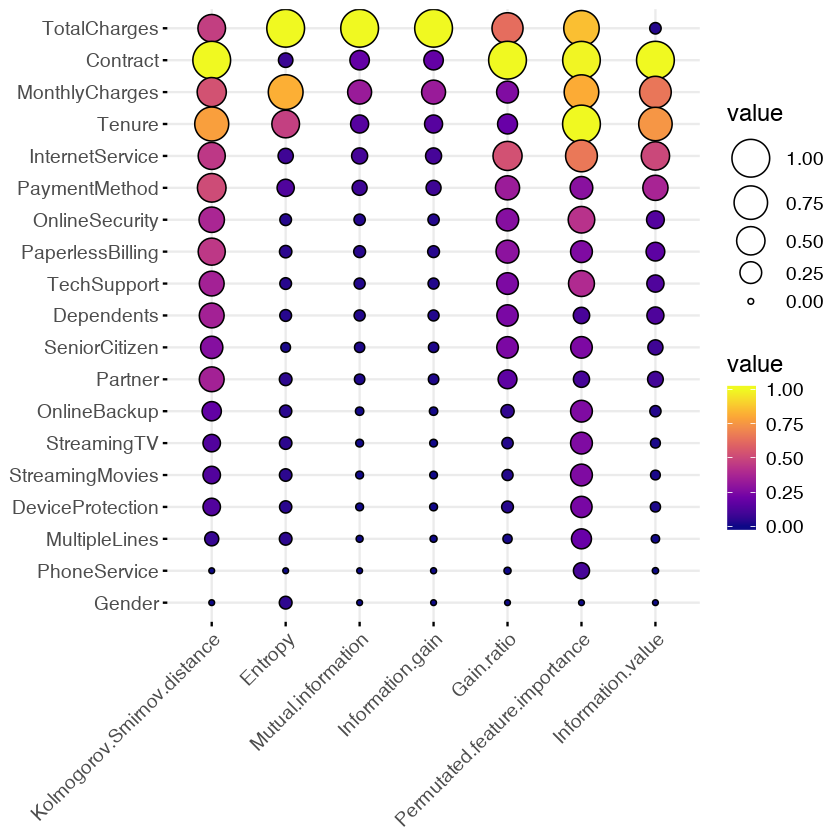

In [21]:
## Import libraries
library(ggplot2)
library(ggpubr)

## Make balloon plot
ggballoonplot(within(dfNorm, rm('Mean')), fill = "value") +
  scale_fill_viridis_c(option = "C") +
  theme(text = element_text(size=14))

ggsave('./merged_var_imp.png')

We see that there is largely agreement between the feature importances measured by the various methods. Interestingly, whereas certain metrics assign fairly high importance to majority of the features, such as Kolmogorov-Smirnov distance as implemented by `autoEDA` and permutation random forest feature importance by `boruta`, the information theory-based metrics implemented by `funModeling` and `scorecard` appear to be more stringent, with only ~3-5 features deemed to be highly predictive of churn. This diversity of perspectives is key to making balanced judgments regarding feature importance.

Phew, we are done for part 1! 

Pretty cool right? Without explicitly building a machine learning model ourselves, we are able to get a sense of which input features are most informative of customers' tendencies to churn. These results will inform our choice of features and models when we start to build classifiers to predict who will go and who will stay.

As always, any comments or suggestions for improvements will be greatly appreciated!

Til next time! :)